# PyTorch神经网络
用PyTorch定义如下的手写数字识别网络：
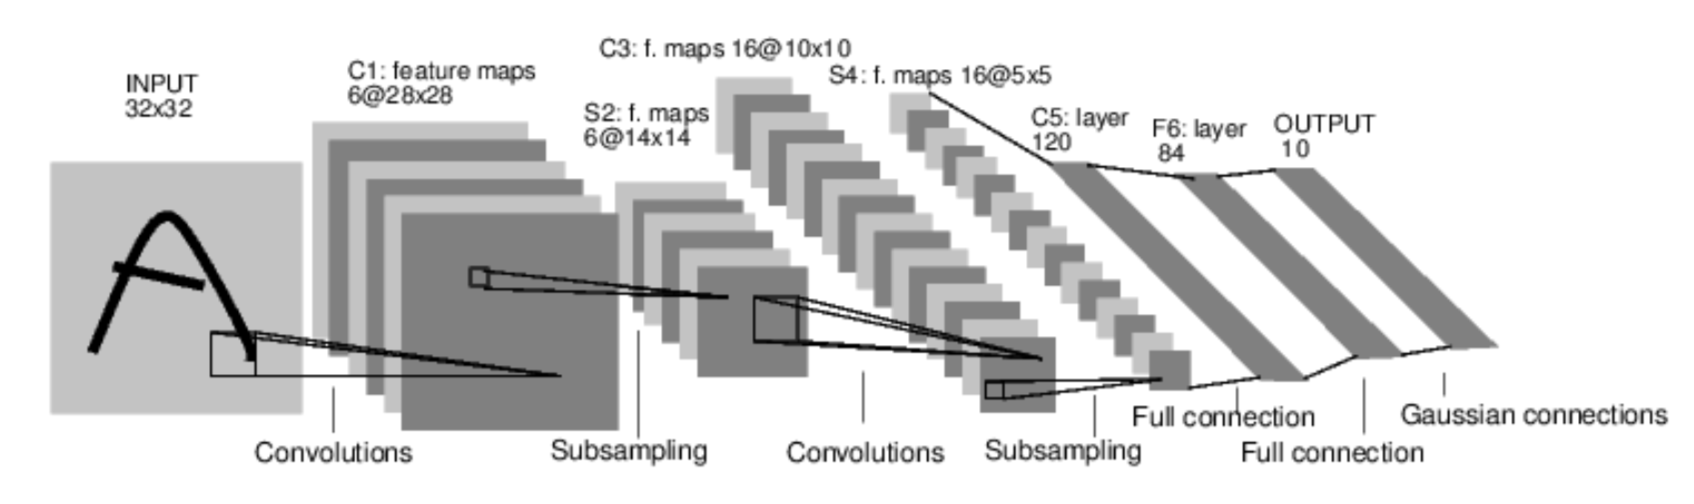
网络定义时包含以下6点：
1. 定义一个包含可训练参数的神经网络
2. 迭代整个输入
3. 通过神经网络处理输入
4. 计算损失(loss)
5. 反向传播梯度到神经网络的参数
6. 更新网络的参数

In [1]:
# 定义网络

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义需要的层
        self.conv1 = nn.Conv2d(1, 6, 5) #输入channel 1, 输出channel 6，kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, 5) #输入channel 6, 输出channel 16，kernel size 5x5
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # 定义前馈函数，输入x，输出x；反向传播函数被自动通过autograd定义了
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) #或者x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x)) #第一维是batch_size，后面所有维展平
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net) #打印的是层，不是前馈网络

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
# 获取可训练参数
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [3]:
# 输入网络进行预测
input = torch.randn(1, 1, 32, 32)
output = net(input)
print(output)

tensor([[-0.0131, -0.0292, -0.0006,  0.0162,  0.0676, -0.0785,  0.0156,  0.0086,
          0.0049, -0.0346]], grad_fn=<AddmmBackward>)


In [4]:
# 测试一下反向传播
net.zero_grad()
output.backward(torch.randn(1, 10), retain_graph=True) #因为输出是一个1x10的向量
print(params[0].grad)

tensor([[[[ 1.2653e-02,  2.2411e-02, -6.3063e-02, -2.9248e-02,  2.4052e-02],
          [ 3.0769e-02, -8.8554e-03, -1.1994e-02,  1.6999e-02, -5.4538e-02],
          [ 5.5544e-02,  8.8053e-03,  6.9131e-02,  3.2569e-02, -8.6351e-02],
          [ 1.3518e-01, -7.9055e-02,  1.3905e-02,  4.7646e-03,  1.5990e-02],
          [ 3.8948e-02,  8.4619e-03,  6.8079e-02, -3.8493e-02,  5.8757e-02]]],


        [[[ 9.6581e-02, -7.6097e-02,  3.9951e-02, -1.9618e-02,  3.1858e-02],
          [ 7.2378e-02, -3.1488e-02, -7.9605e-02, -1.9653e-02,  5.2810e-02],
          [-6.7818e-02,  1.0676e-01, -2.9174e-02,  7.2931e-02, -4.3896e-02],
          [ 2.0323e-01,  7.5000e-03, -1.2793e-02, -4.7749e-03,  9.9586e-02],
          [-2.5331e-02, -5.2416e-02, -1.3968e-01,  6.5329e-02,  1.2486e-02]]],


        [[[-6.7540e-02, -7.5510e-02,  3.4234e-02, -5.9548e-02,  2.4783e-02],
          [ 6.0258e-02,  2.4200e-02, -2.7702e-02, -1.7662e-03,  1.2035e-02],
          [-1.0337e-01, -1.6762e-02, -9.8508e-02,  1.1815e-02, -1.34

In [5]:
# 计算损失
target = torch.randn(10) #一个样本的y，1x10的向量
print(target)
criterion = nn.MSELoss() #初始化loss类对象criterion
loss = criterion(output, target) #计算loss
print(loss)

tensor([-1.3148,  1.4327, -0.3947,  0.0563,  2.9198,  1.5893, -0.0203,  0.4555,
        -1.3118, -1.6070])
tensor(1.9313, grad_fn=<MseLossBackward>)


/Users/gaoxuanxuan/anaconda3/envs/tensorflow1_13/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [6]:
# 查看反向传播路径 
print(loss.grad_fn) #MSELoss
print(loss.grad_fn.next_functions[0][0]) # Linear 
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # ReLU

In [7]:
# 正式进行反向传播前需要清空现存的梯度，要不然帝都将会和现存的梯度累计到一起。
net.zero_grad() # zeroes the gradient buffers of all parameters

# 比对一下反向传播前后某参数的梯度
print('conv1.bias.grad before backward') 
print(net.conv1.bias.grad)
loss.backward(retain_graph=True)
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0349,  0.0406,  0.0139, -0.0125,  0.0366, -0.0085])


In [8]:
# https://zhuanlan.zhihu.com/p/47749934
# 模型训练时提示 RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.
# 该问题是指在默认情况下，网络在反向传播中不允许多个backward()。需要在第一个backward设置retain_graph=True
# 解决办法：
# loss.backward()改为loss.backward(retain_graph=True)

In [9]:
# 更新参数

# 1.自己实现的随机梯度下降
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

# 2.调包
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01)
# in your training loop:
optimizer.zero_grad() # zero the gradient buffers output = net(input)
print(net.conv1.bias.grad)
loss = criterion(output, target)
loss.backward(retain_graph=True)
optimizer.step() # 更新梯度
print(net.conv1.bias.grad)
loss.backward(retain_graph=True)
optimizer.step() # 更新梯度
print(net.conv1.bias.grad)

tensor([0., 0., 0., 0., 0., 0.])
tensor([-0.0350,  0.0348,  0.0054, -0.0205,  0.0332, -0.0106])
tensor([-0.0699,  0.0637,  0.0024, -0.0489,  0.0631, -0.0232])
